In [36]:
from pathlib import Path

import requests
import yaml


In [37]:
config_path = Path("/home/jam/privat/radar/config.yaml")
with config_path.open(encoding="utf-8") as file:
    cfg = yaml.safe_load(file)

In [38]:
api_url_base = "https://dmigw.govcloud.dk/"
api_path = f"v1/radardata/collections/composite/items?api-key={cfg["API_KEY"]}"
response = requests.get(api_url_base + api_path)
response.json()

{'type': 'FeatureCollection',
 'features': [{'stac_version': '1.0.0',
   'bbox': [4.379082700525593,
    52.29427206432812,
    20.735140174892805,
    59.827708427801085],
   'geometry': {'coordinates': [[[4.379082700525593, 52.29427206432812],
      [20.735140174892805, 52.29427206432812],
      [20.735140174892805, 59.827708427801085],
      [4.379082700525593, 59.827708427801085],
      [4.379082700525593, 52.29427206432812]]],
    'type': 'Polygon'},
   'collection': 'composite',
   'id': 'dk.com.202503140410.500_max.h5',
   'asset': {'data': {'href': 'https://dmigw.govcloud.dk/v1/radardata/download/dk.com.202503140410.500_max.h5?api-key=2894b92c-43c9-48a6-9065-8f565d288f3c',
     'title': 'Radar file download resource',
     'type': 'application/x-hdf5',
     'roles': ['data']}},
   'type': 'Feature',
   'properties': {'created': '2025-03-14T04:22:05.278Z',
    'datetime': '2025-03-14T04:10:00Z',
    'scanType': 'fullRange'}},
  {'stac_version': '1.0.0',
   'bbox': [4.37908270052

Download link: https://dmigw.govcloud.dk/v1/radardata/download/dk.com.YYYYMMDDHHMM.500_max.h5?api-key=<api>
Example: https://dmigw.govcloud.dk/v1/radardata/download/dk.com.202509101410.500_max.h5?api-key=<api>

In [39]:
import h5py
from pathlib import Path

path = Path("/home/jam/privat/radar/data/dk.com.202509101410.500_max.h5")
with h5py.File(path, "r") as f:
    # List top-level keys
    print("Top-level groups/datasets:", list(f.keys()))

    def walk(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(
                f"DATASET: {name} shape={obj.shape} dtype={obj.dtype} attrs={list(obj.attrs.keys())}"
            )
        elif isinstance(obj, h5py.Group):
            print(f"GROUP:   {name} attrs={list(obj.attrs.keys())}")

    f.visititems(walk)

Top-level groups/datasets: ['dataset1', 'how', 'what', 'where']
GROUP:   dataset1 attrs=[]
GROUP:   dataset1/data1 attrs=['quantity']
DATASET: dataset1/data1/data shape=(1728, 1984) dtype=uint8 attrs=['CLASS', 'IMAGE_VERSION']
GROUP:   how attrs=['zr-a', 'zr-b']
GROUP:   what attrs=['date', 'gain', 'nodata', 'object', 'offset', 'product', 'source', 'time', 'undetect', 'version']
GROUP:   where attrs=['LL_lat', 'LL_lon', 'LR_lat', 'LR_lon', 'UL_lat', 'UL_lon', 'UR_lat', 'UR_lon', 'projdef', 'xscale', 'yscale']


In [40]:
import xarray as xr
import numpy as np
import h5py


with h5py.File(path, "r") as f:
    dset = f["dataset1"]["data1"]["data"]
    arr = dset[...]
    xr_da = xr.DataArray(
        arr,
        dims=("y", "x"),  # adjust as needed
        attrs=dict(dset.attrs),
    )
    where = f["where"]
    print(where)

<HDF5 group "/where" (0 members)>


In [41]:
where

<Closed HDF5 group>

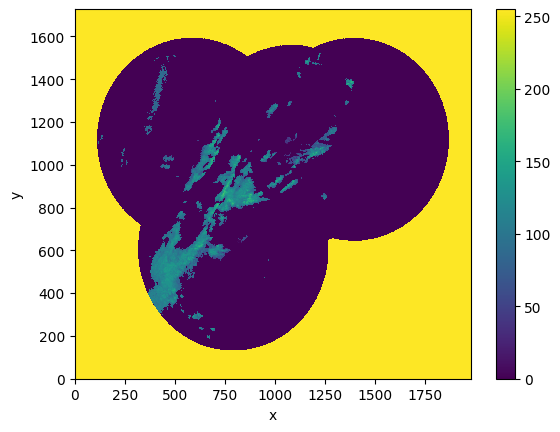

In [42]:
xr_da.plot()

In [43]:
# New cell: build xarray DataArray with (time, y, x) and lat/lon coords
import h5py
import numpy as np
import xarray as xr
from pathlib import Path
from datetime import datetime

path = Path("/home/jam/privat/radar/data/dk.com.202509101410.500_max.h5")

with h5py.File(path, "r") as f:
    data = f["dataset1"]["data1"]["data"][...]  # (ny, nx) uint8
    quantity = f["dataset1"]["data1"].attrs.get("quantity", b"var")
    if isinstance(quantity, bytes):
        quantity = quantity.decode()

    what = f["what"].attrs
    where = f["where"].attrs

    # Decode bytes -> python types
    def _val(a):
        return a.decode() if isinstance(a, (bytes, bytearray)) else a

    date_str = _val(what["date"])  # 'YYYYMMDD'
    time_str = _val(what["time"])  # 'HHMMSS'
    ts = datetime.strptime(date_str + time_str, "%Y%m%d%H%M%S")

    gain = float(what.get("gain", 1.0))
    offset = float(what.get("offset", 0.0))
    nodata = what.get("nodata", None)
    undetect = what.get("undetect", None)

    # Scale data
    scaled = data.astype("float32") * gain + offset

    # Mask
    mask = np.zeros_like(scaled, dtype=bool)
    if nodata is not None:
        mask |= data == nodata
    if undetect is not None:
        mask |= data == undetect
    scaled = np.ma.masked_array(scaled, mask=mask)

    ny, nx = data.shape

    # Corner coordinates
    UL_lat, UL_lon = float(where["UL_lat"]), float(where["UL_lon"])
    UR_lat, UR_lon = float(where["UR_lat"]), float(where["UR_lon"])
    LL_lat, LL_lon = float(where["LL_lat"]), float(where["LL_lon"])
    LR_lat, LR_lon = float(where["LR_lat"]), float(where["LR_lon"])

    # Bilinear interpolation of lat/lon over the pixel grid
    wx = np.linspace(0.0, 1.0, nx)  # left->right
    wy = np.linspace(0.0, 1.0, ny)  # top->bottom

    top_lat = UL_lat + wx * (UR_lat - UL_lat)
    top_lon = UL_lon + wx * (UR_lon - UL_lon)
    bottom_lat = LL_lat + wx * (LR_lat - LL_lat)
    bottom_lon = LL_lon + wx * (LR_lon - LL_lon)

    lat2d = (top_lat * (1 - wy[:, None])) + (bottom_lat * wy[:, None])
    lon2d = (top_lon * (1 - wy[:, None])) + (bottom_lon * wy[:, None])

    da = xr.DataArray(
        scaled[np.newaxis, ...],  # add time dim
        dims=("time", "y", "x"),
        coords=dict(
            time=[np.datetime64(ts)],
            lat=(("y", "x"), lat2d),
            lon=(("y", "x"), lon2d),
        ),
        name=quantity,
        attrs={
            "gain": gain,
            "offset": offset,
            "nodata": nodata,
            "undetect": undetect,
            "projection": _val(where.get("projdef", "")),
            "description": quantity,
            "source": _val(what.get("source", "")),
            "product": _val(what.get("product", "")),
        },
    )

da

/tmp/ipykernel_28643/972345678.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  UL_lat, UL_lon = float(where["UL_lat"]), float(where["UL_lon"])
/tmp/ipykernel_28643/972345678.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  UR_lat, UR_lon = float(where["UR_lat"]), float(where["UR_lon"])
/tmp/ipykernel_28643/972345678.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  LL_lat, LL_lon = float(where["LL_lat"]), float(where["LL_lon"])
/tmp/ipykernel_28643/9723

<xarray.DataArray 'DBZH' (time: 1, y: 1728, x: 1984)> Size: 14MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(1, 1728, 1984), dtype=float32)
Coordinates:
  * time     (time) datetime64[us] 8B 2025-09-10T14:10:01
    lat      (y, x) float64 27MB 60.0 60.0 60.0 60.0 ... 52.29 52.29 52.29 52.29
    lon      (y, x) float64 27MB 3.0 3.009 3.018 3.027 ... 18.88 18.89 18.89
Dimensions without coordinates: y, x
Attributes:
    gain:         0.5
    offset:       -32.0
    nodata:       255
    undetect:     0.0
    projection:   +proj=stere +ellps=WGS84 +lat_0=56 +lon_0=10.5666 +lat_ts=56
    description:  DBZH
    source:       DMI-RADARGROUP
    product:      DBZH

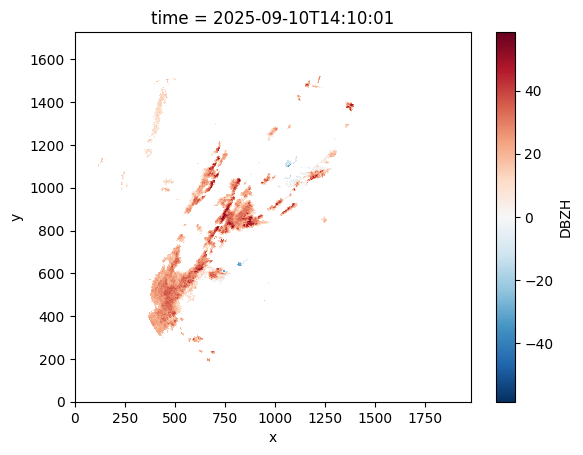

In [44]:
da.plot()

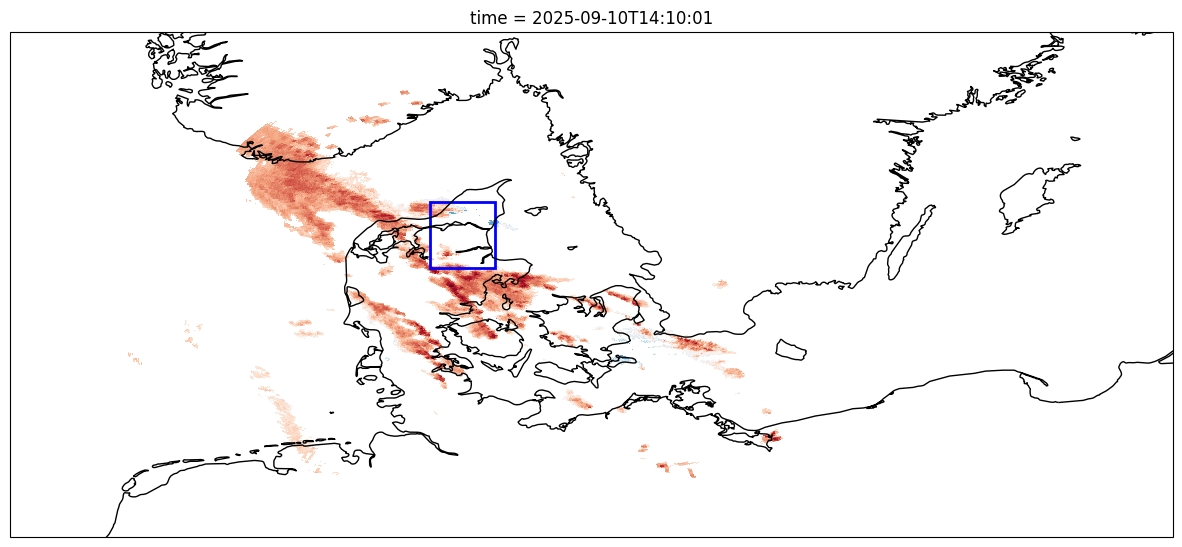

In [45]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(15, 10))
ax1 = plt.axes(projection=proj)
da.isel(time=0).plot.pcolormesh(
    ax=ax1,
    transform=proj,
    x="lon",
    y="lat",
    add_colorbar=False,
)

rect1 = Rectangle((9.4, 56.4), 1, 1, color="blue", fc="none", lw=2)

ax1.add_patch(rect1)

ax1.coastlines()

plt.gcf().set_size_inches(15, 10)
plt.show()